# Clustering and outlier detection

In this analysis, we want to assign labels to data using clustering and outlier detection. Given that we actually have the labels in the data, we then compare these methods.

The data we are using here comes from http://odds.cs.stonybrook.edu/annthyroid-dataset/. The label considered here is whether a patient referred to the clinic is hypothyroid.

In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cluster import KMeans,AgglomerativeClustering, DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import roc_auc_score, average_precision_score, silhouette_samples,normalized_mutual_info_score,adjusted_mutual_info_score
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from scipy.cluster.hierarchy import dendrogram, linkage
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline

def scatter_tab(x, y, c, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    ax.scatter(x, y, c=plt.cm.tab10(c), **kwargs)

In [2]:
data=loadmat("annthyroid.mat")

In [3]:
X=pd.DataFrame(data["X"])
X["label"]=data["y"]

# Visualization

## 1.1

## Jointly Univariate distributions of the features 

We can see that there is extreme outliers for feature 1, and smaller outliers for feature 2, 3 and 5. For feature 0, we can guess that the two "bumps" in the distribution correspond to two different clusters.

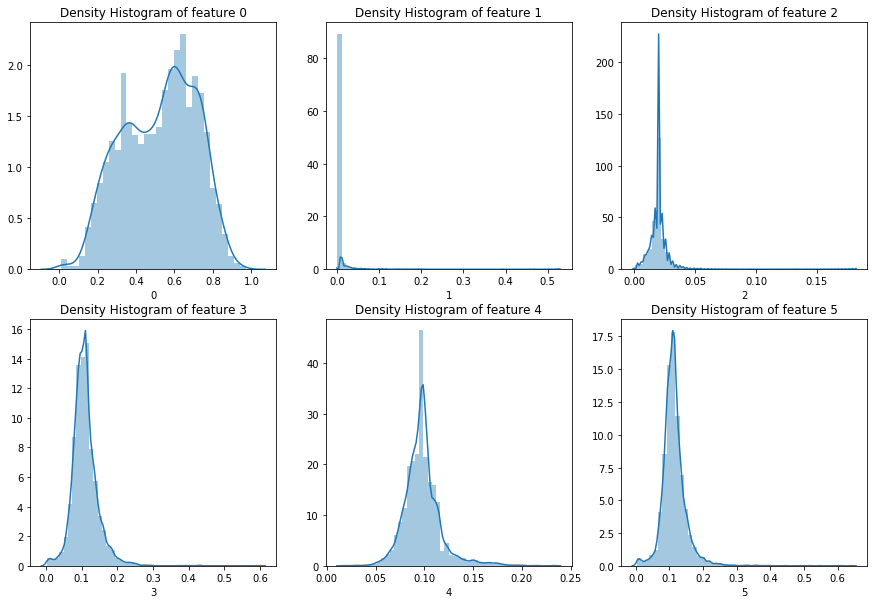

In [4]:
fig,ax=plt.subplots(2,3,figsize=(15,10))
k=0
for i in range(2):
    for j in range(3):
        sns.distplot(X[k], ax=ax[i][j],norm_hist=True)
        ax[i][j].set_title("Density Histogram of feature {}".format(k))
        k+=1
    

##  Per class  Univariate distributions of the features 

When visualizing the univariate distribution per class, we notice that there is less data and also less outliers in class 1

### Class 0

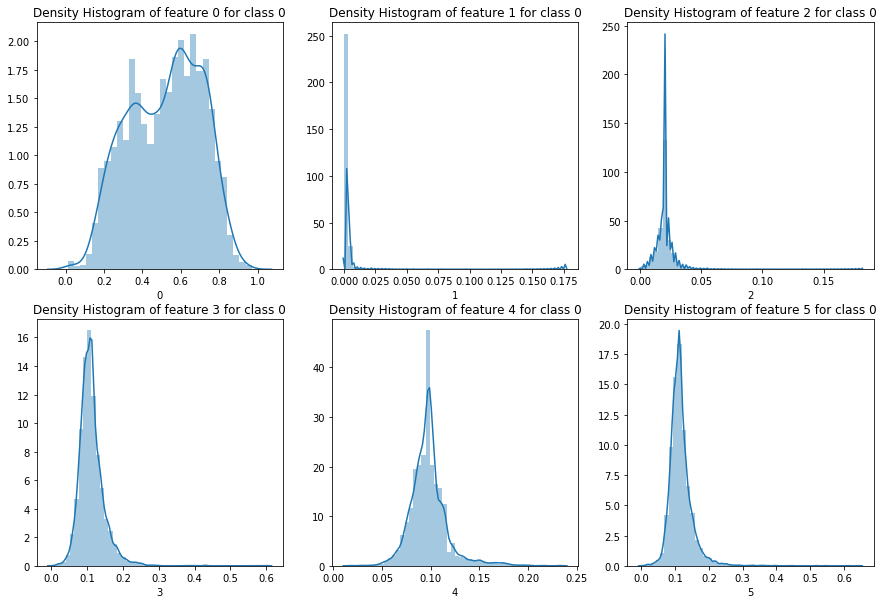

In [5]:
fig,ax=plt.subplots(2,3,figsize=(15,10))
k=0
for i in range(2):
    for j in range(3):
        sns.distplot(X[k][X.label==0], ax=ax[i][j],norm_hist=True)
        ax[i][j].set_title("Density Histogram of feature {} for class 0".format(k))
        k+=1
    

### Class 1 

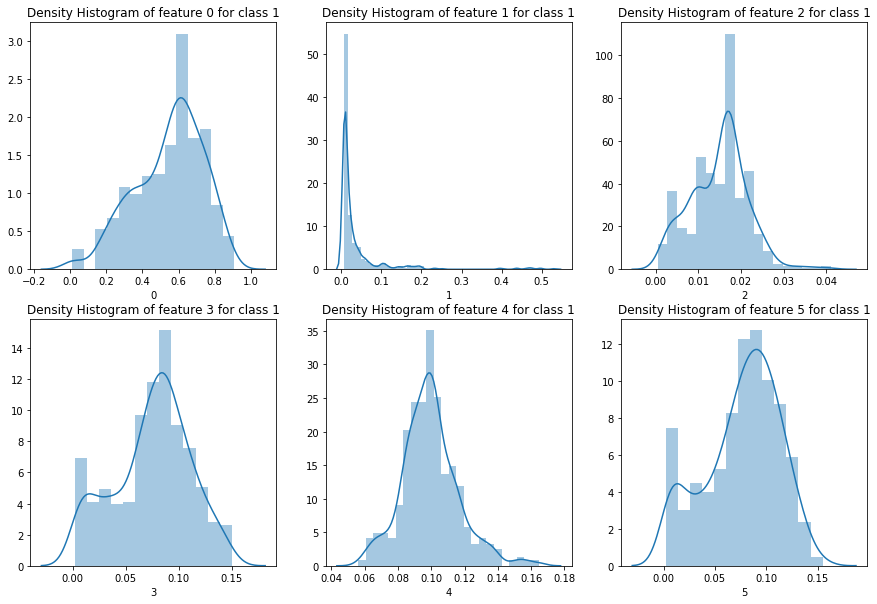

In [6]:
fig,ax=plt.subplots(2,3,figsize=(15,10))
k=0
for i in range(2):
    for j in range(3):
        sns.distplot(X[k][X.label==1], ax=ax[i][j],norm_hist=True)
        ax[i][j].set_title("Density Histogram of feature {} for class 1".format(k))
        k+=1

## Visualize the data using PCA

Text(0,0.5,'second principal component')

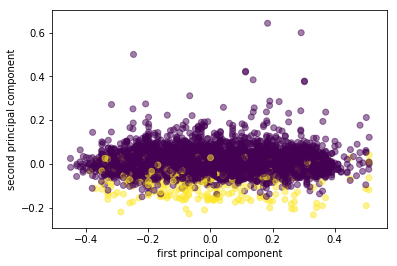

In [7]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.drop('label',axis=1))
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=X.label,alpha=0.5)
plt.xlabel("first principal component")
plt.ylabel("second principal component")

If we visualize the explained variance ratio, we notice a clear "elbow" after two components (the ratio doesn't decrease as much) so n_components=2 seems to be a good choice.

Text(0.5,1,'Explained variance ratio ')

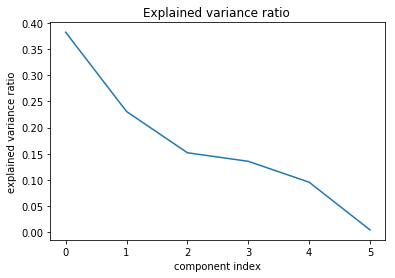

In [8]:
pca_scaled = make_pipeline(StandardScaler(), PCA())
pca_scaled.fit(X.drop('label',axis=1))
pca = pca_scaled.named_steps['pca']


plt.plot(pca.explained_variance_ratio_)
plt.xlabel("component index")
plt.ylabel("explained variance ratio")
plt.title("Explained variance ratio ")

## 1.2

## Visualize the data using t-SNE.


We can see that for perplexity=20, the two clusters are already well distinct.

In [ ]:
for perplexity in [2, 5, 20, 50,]:
    plt.figure()
    plt.xticks(())
    plt.yticks(())
    X_tsne = TSNE(perplexity=perplexity).fit_transform(X.drop('label',axis=1))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=X.label)
    plt.title("perplexity = {}".format(perplexity))

# Clustering 

In this part, we act as if we did not know if patients were hypothyroid or not, and use clustering to try to detect this in an unsupervised way


## 2.1

### Kmeans

Kmeans is sensitive to scaling, and data should obviously be scaled before any modeling. Below, we showcase the difference between before and after scaling

km without scaling : [4113 3087]


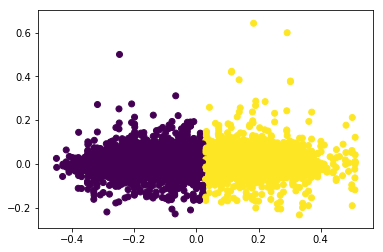

In [9]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.drop('label',axis=1))
km = KMeans(n_clusters=2, random_state=0)
km.fit(X.drop('label',axis=1))
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=km.labels_)
print("{} : {}".format("km without scaling", np.sort(np.bincount(km.labels_))[::-1]))

With scaling : We can see that with scaling, the knn clusters look much more distinct from one another (based on the first two components of the PCA). The clusters are much more balanced. It would make sense to use scaling for this data.

km with scaling : [5348 1852]


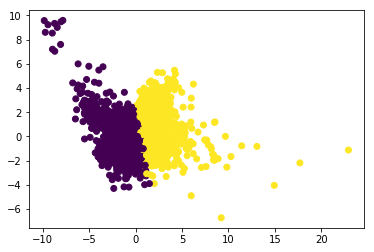

In [10]:
pca = PCA(n_components=2)
X_scaled=StandardScaler().fit_transform(X.drop('label',axis=1))
X_pca_scaled = pca.fit_transform(X_scaled)
km = KMeans(n_clusters=2, random_state=0)
km.fit(X_scaled)
plt.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1],c=km.labels_)
print("{} : {}".format("km with scaling", np.sort(np.bincount(km.labels_))[::-1]))

### Agglomerative Clustering

Here the ward merging criteria might be the most adapted since the  cluster size are really uneven.

average : [7198    2]
complete : [7190   10]
ward : [6378  822]


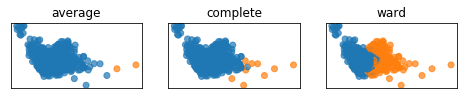

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3), subplot_kw={"xticks":(), "yticks": ()})
for ax, link in zip(axes, ["average", "complete", 'ward']):
    agg = AgglomerativeClustering(n_clusters=2, linkage=link)
    agg.fit(X_scaled)
    ax.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=plt.cm.tab10(agg.labels_), alpha=.7)
    ax.set_title(link)
    ax.set_aspect("equal")
    print("{} : {}".format(link, np.sort(np.bincount(agg.labels_))[::-1]))

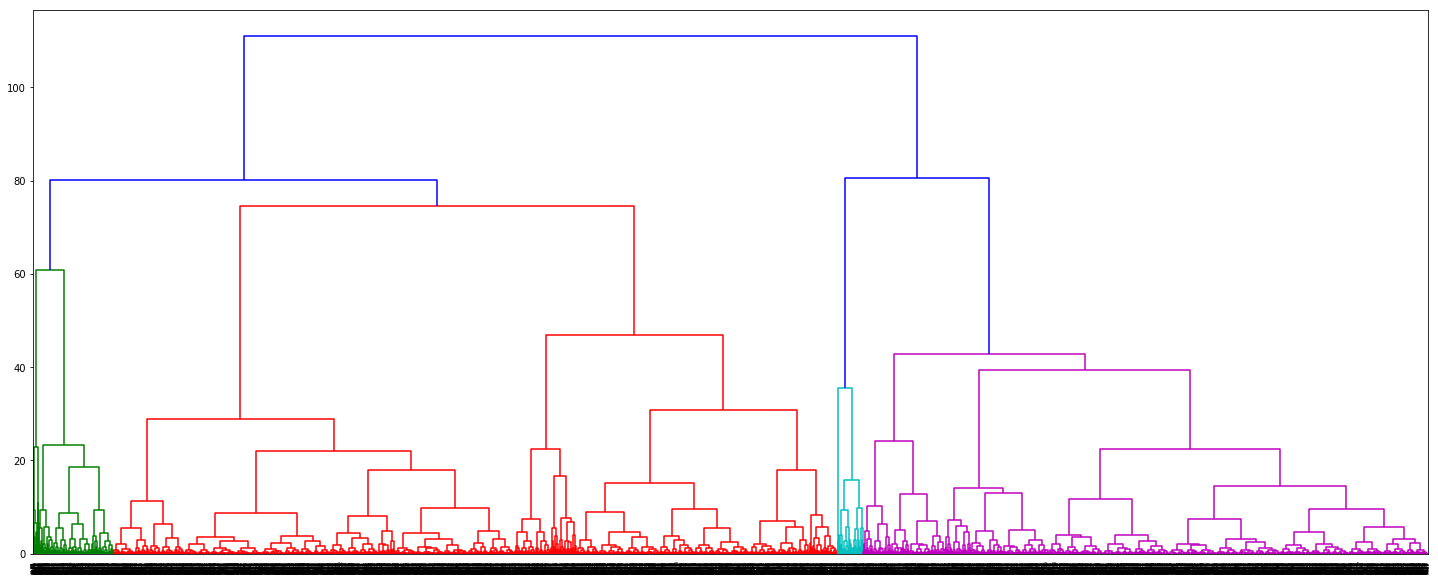

In [12]:
Z = linkage(X_pca_scaled,method='ward') 
plt.figure(figsize=(25, 10))
dn = dendrogram(Z,truncate_mode='level')

 ### DBSCAN 

DBSCAN has trouble identifying more than one cluster. Visually,we can see why it would only go for one cluster. It might therefore not be suited for this dataset, where we already know that we want two clusters. In the plots, the black dots are the outliers: eps=1.1 seems like a good parameter.

10 0.4
number of clusters : 7


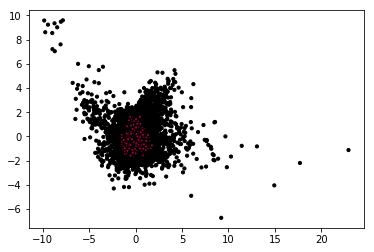

10 0.5
number of clusters : 2


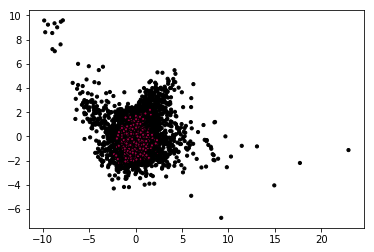

10 0.6
number of clusters : 1


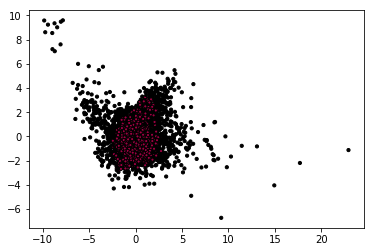

10 0.7
number of clusters : 1


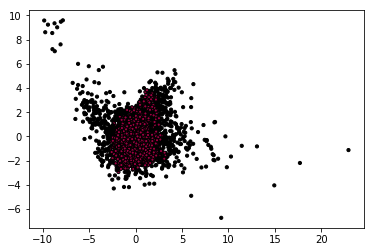

10 0.8
number of clusters : 1


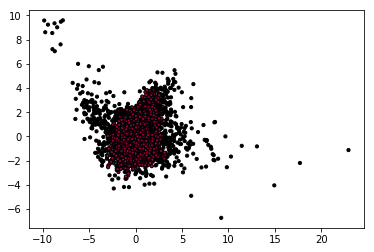

10 0.9
number of clusters : 2


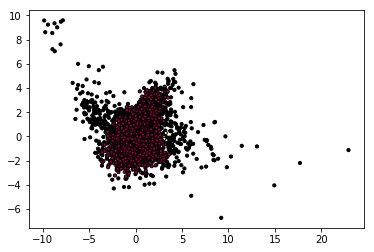

10 1.0
number of clusters : 2


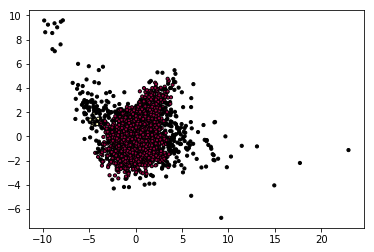

10 1.1
number of clusters : 1


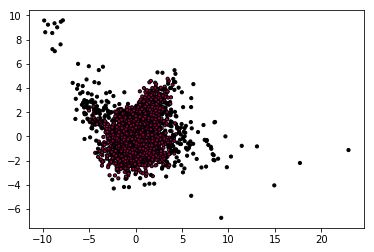

10 1.2
number of clusters : 2


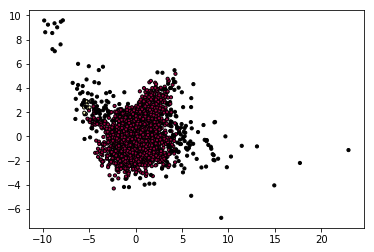

10 1.3
number of clusters : 1


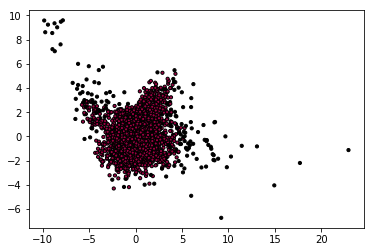

10 1.4
number of clusters : 1


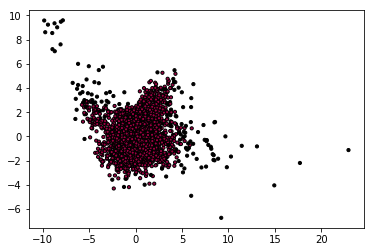

20 0.4
number of clusters : 1


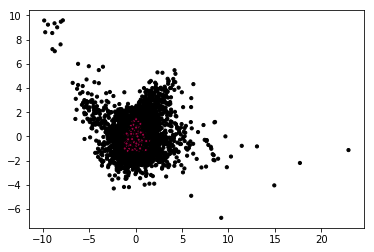

20 0.5
number of clusters : 2


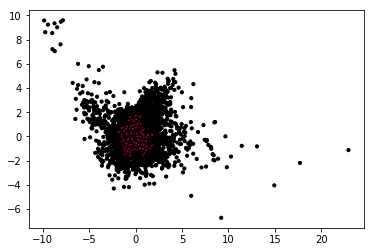

20 0.6
number of clusters : 1


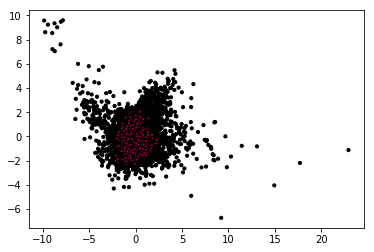

20 0.7
number of clusters : 1


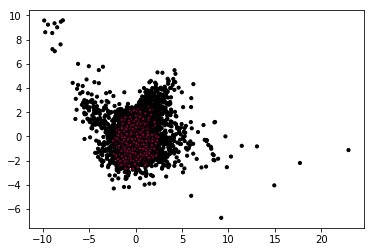

20 0.8
number of clusters : 1


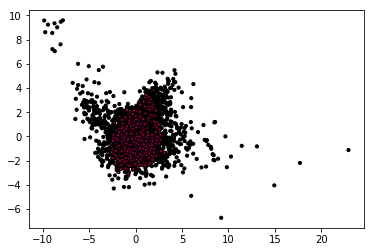

20 0.9
number of clusters : 1


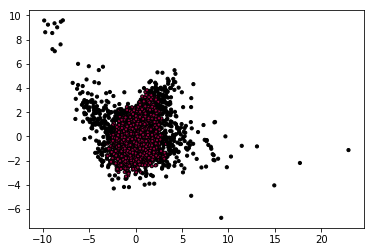

20 1.0
number of clusters : 1


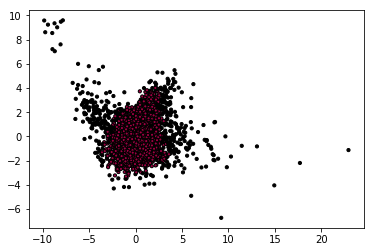

20 1.1
number of clusters : 1


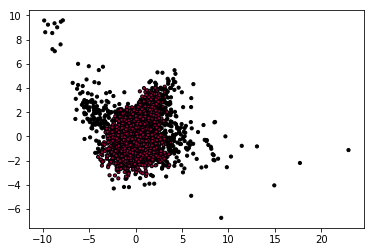

20 1.2
number of clusters : 1


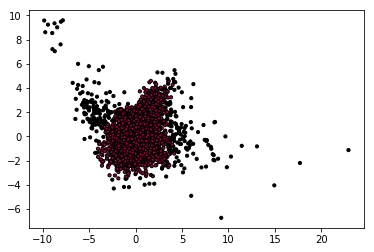

20 1.3
number of clusters : 1


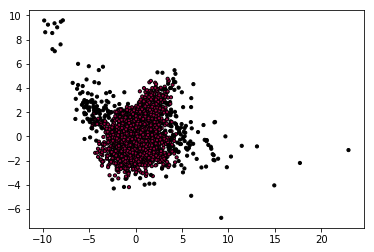

20 1.4
number of clusters : 1


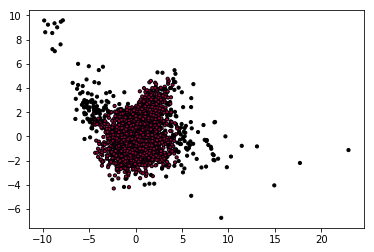

30 0.4
number of clusters : 1


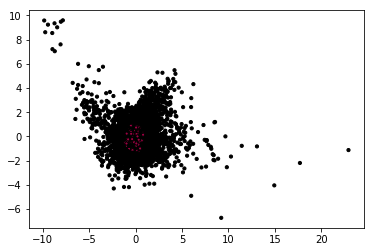

30 0.5
number of clusters : 1


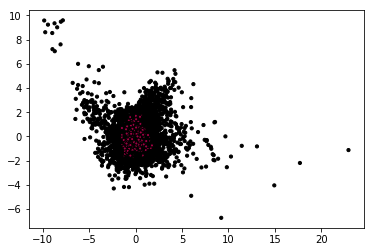

30 0.6
number of clusters : 1


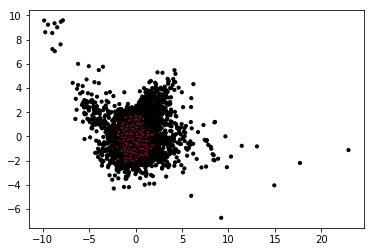

30 0.7
number of clusters : 1


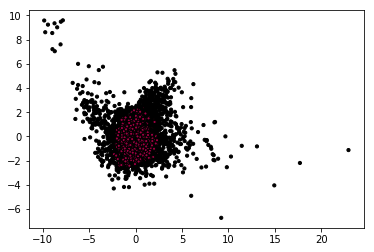

30 0.8
number of clusters : 1


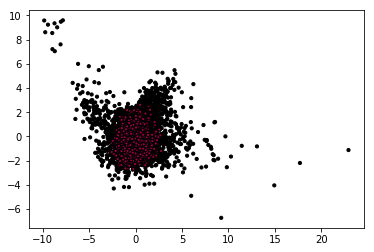

30 0.9
number of clusters : 1


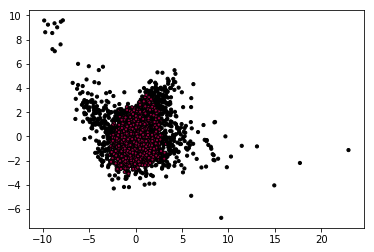

30 1.0
number of clusters : 1


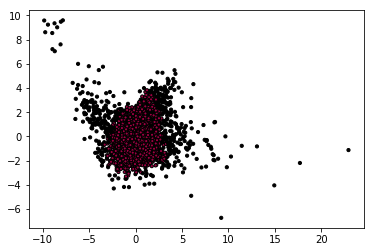

30 1.1
number of clusters : 1


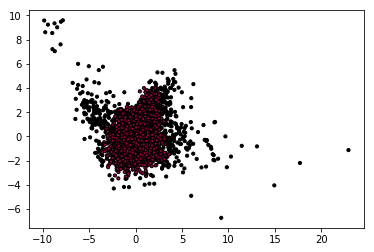

30 1.2
number of clusters : 1


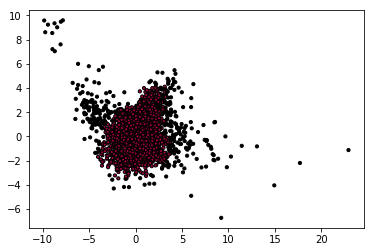

30 1.3
number of clusters : 1


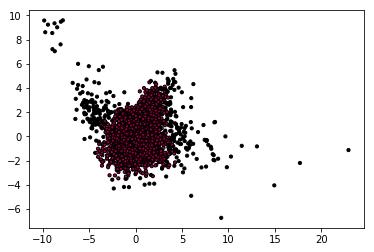

30 1.4
number of clusters : 1


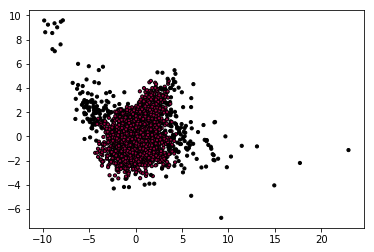

40 0.4
number of clusters : 1


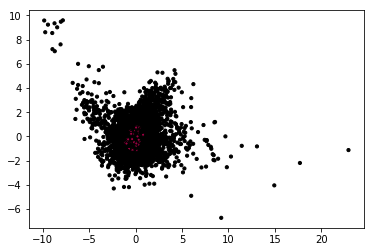

40 0.5
number of clusters : 1


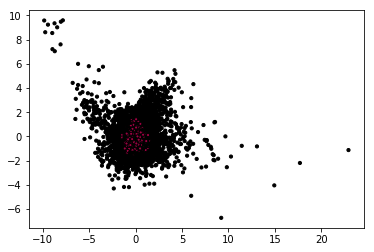

40 0.6
number of clusters : 1


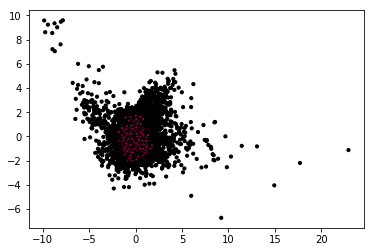

40 0.7
number of clusters : 1


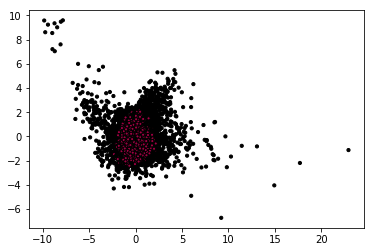

40 0.8
number of clusters : 1


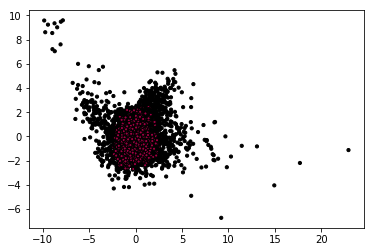

40 0.9
number of clusters : 1


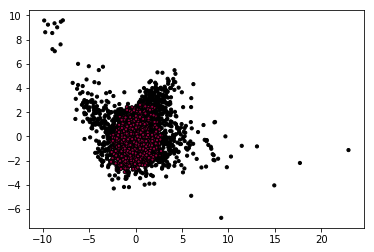

40 1.0
number of clusters : 1


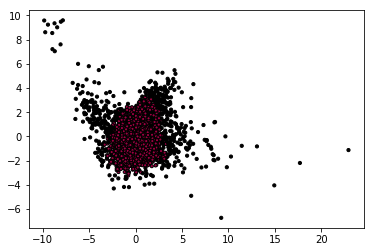

40 1.1
number of clusters : 1


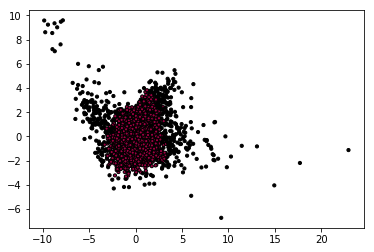

40 1.2
number of clusters : 1


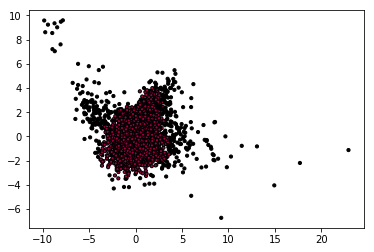

40 1.3
number of clusters : 1


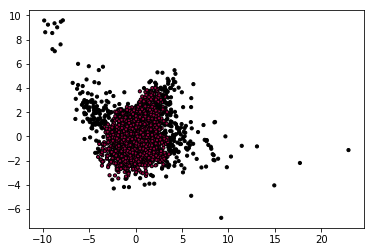

40 1.4
number of clusters : 1


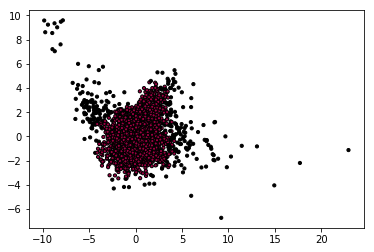

In [13]:
for min_samples in np.arange(10,50,10):
    for eps in np.arange(4,15)/10:
        dbscan = DBSCAN(min_samples=min_samples, eps=eps)
# get cluster assignments
        clusters = dbscan.fit_predict(X_scaled)
        print(min_samples,eps)
        labels=dbscan.labels_
        unique_labels = set(labels)
        n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)
        print("number of clusters : {}".format(n_clusters_))
        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
        if np.any(clusters == -1):
            c = [(0, 0, 0, 1)] + colors
            clusters = clusters + 1
        else:
            c = colors
        c = np.array(c)
        plt.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=c[clusters], s=10, edgecolor="k")
        plt.show()

## 2.2

### KMEANS

Unsurpisingly, the Kmeans performs better on scaled data if we compare it to the ground truth labels.

In [14]:
km = KMeans(n_clusters=2, random_state=0)
km.fit(X.drop('label',axis=1))
ari = adjusted_mutual_info_score(X.label, km.labels_)
nmi = normalized_mutual_info_score(X.label, km.labels_)
print("without scaling, ari = {}, nmi = {}".format(ari,nmi))

without scaling, ari = 0.0022201578746287756, nmi = 0.003732234107965867


In [15]:
km = KMeans(n_clusters=2, random_state=0)
km.fit(X_scaled)
ari = adjusted_mutual_info_score(X.label, km.labels_)
nmi = normalized_mutual_info_score(X.label, km.labels_)
print("with scaling, ari = {}, nmi = {}".format(ari,nmi))

with scaling, ari = 0.017530708315014687, nmi = 0.02592438301263815


### Agglomerative clustering

As we expected,the "ward" method gives better scores. The scores are still very low using that method, a bit lower than Kmeans.

In [16]:
for ax, link in zip(axes, ["average", "complete", 'ward']):
    agg = AgglomerativeClustering(n_clusters=2, linkage=link)
    agg.fit(X_scaled)
    ari = adjusted_mutual_info_score(X.label, agg.labels_)
    nmi = normalized_mutual_info_score(X.label, agg.labels_)
    print("linkage {}, ari = {}, nmi = {}".format(link,ari,nmi))

linkage average, ari = -9.67965662315698e-05, nmi = 0.0008243011509894826
linkage complete, ari = 0.00010825619472411405, nmi = 0.002030729867479826
linkage ward, ari = 0.014444961470317489, nmi = 0.016968780534124893


 ### DBSCAN 

Looking at the ari and nmi scores for DBSCAN, it seems that eps=0.9 with in_samples=10 are the best parameters, with an ari score of 0.08174 anda nmi score of  0.08242. DBSCAN has the best scores compared to the other two models.

In [17]:
for min_samples in np.arange(10,50,10):
    for eps in np.arange(4,15)/10:
        dbscan = DBSCAN(min_samples=min_samples, eps=eps)
        dbscan.fit(X_scaled)
        ari = adjusted_mutual_info_score(X.label, dbscan.labels_)
        nmi = normalized_mutual_info_score(X.label, dbscan.labels_)
        print("min_samples {}, ep {} ari = {}, nmi = {}".format(min_samples,eps,ari,nmi))

min_samples 10, ep 0.4 ari = 0.029468910402622183, nmi = 0.05024822623156135
min_samples 10, ep 0.5 ari = 0.03703557248940035, nmi = 0.05510741371631148
min_samples 10, ep 0.6 ari = 0.05169712657710268, nmi = 0.06797337534726439
min_samples 10, ep 0.7 ari = 0.061199032042490824, nmi = 0.07267014787130709
min_samples 10, ep 0.8 ari = 0.07492585422933154, nmi = 0.08081481779676829
min_samples 10, ep 0.9 ari = 0.08173903933348187, nmi = 0.08242658750555512
min_samples 10, ep 1.0 ari = 0.0759264148419885, nmi = 0.08375509807749833
min_samples 10, ep 1.1 ari = 0.054887978761677766, nmi = 0.06743784544519915
min_samples 10, ep 1.2 ari = 0.05143708250505739, nmi = 0.06713454934369582
min_samples 10, ep 1.3 ari = 0.022643109840154142, nmi = 0.033510093778936705
min_samples 10, ep 1.4 ari = 0.018343531607438287, nmi = 0.029300023941514295
min_samples 20, ep 0.4 ari = 0.022002325010002072, nmi = 0.0354583836857719
min_samples 20, ep 0.5 ari = 0.026013455232450182, nmi = 0.041499216959126305
min_

# Task 3 Outlier Detection

In this part, we change the problem to be an outlier detection problem. We suppose here that hypothyroid patients are outliers in our dataset and try to detect them like this. For all these approaches, we use the fact that the part of hypothyroid patients is around 8%.

We try three outlier detection models: Elliptic Envelope, OneClassSVM and Isolation Forests.

# 3.1

In [18]:
len(X[X.label == 1])/len(X[X.label == 0])

0.08010801080108011

In [19]:
X_scaled = StandardScaler().fit_transform(X.drop('label',axis=1))

In [20]:
ee = EllipticEnvelope(contamination=.08).fit(X_scaled)
ee_pred = ee.predict(X_scaled)
print(np.mean(ee_pred == -1))

0.08


In [21]:
oneclass = OneClassSVM(nu=.08).fit(X_scaled)
svm_pred = oneclass.predict(X_scaled)
print(np.mean(svm_pred == -1))

0.08055555555555556


In [22]:
isof = IsolationForest(contamination=.08).fit(X_scaled)
isof_pred = isof.predict(X_scaled)
print(np.mean(isof_pred == -1))

0.08


In [23]:
axes_choice = np.array([(x,y) for x in range(6) for y in range(6) if y!=x])

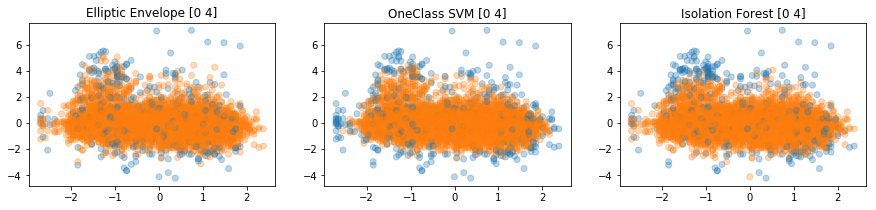

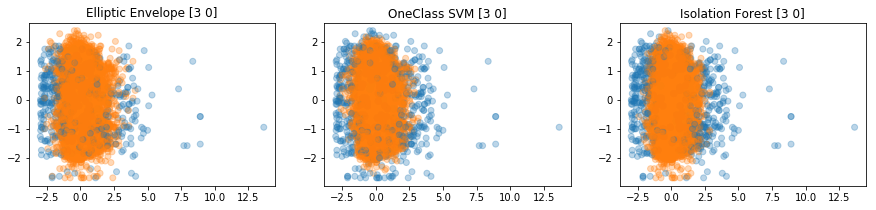

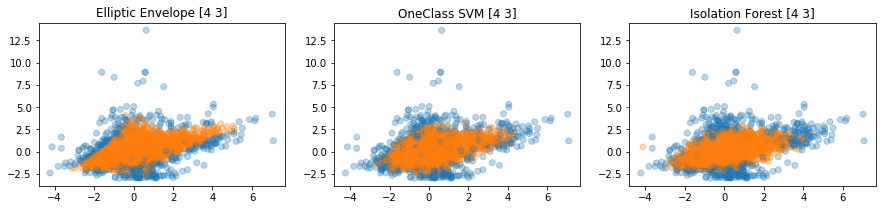

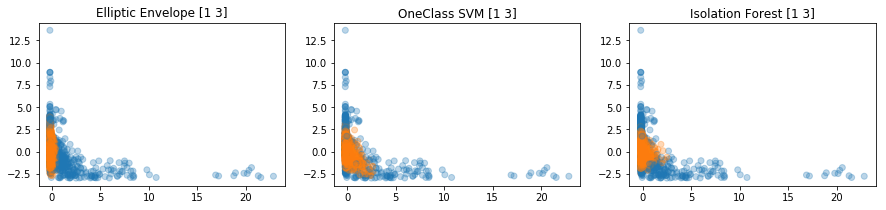

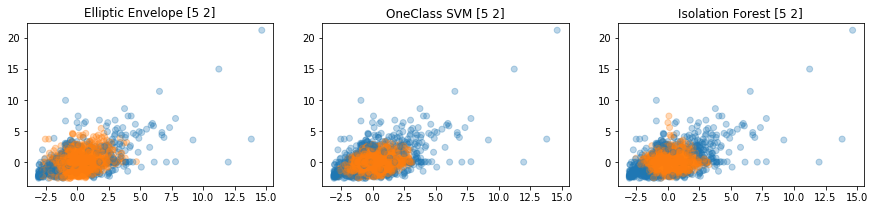

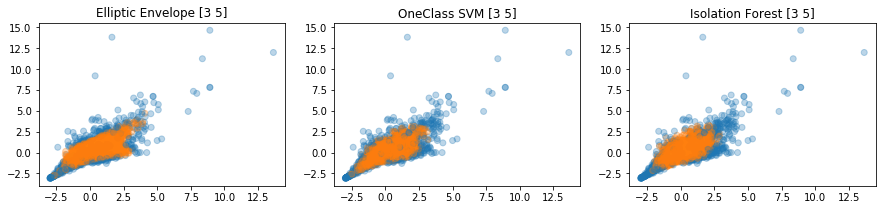

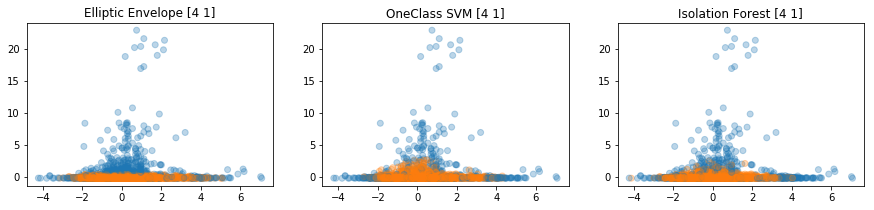

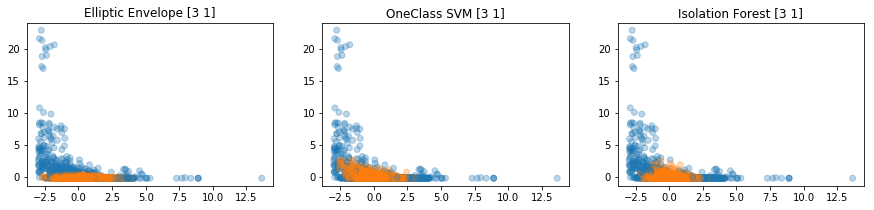

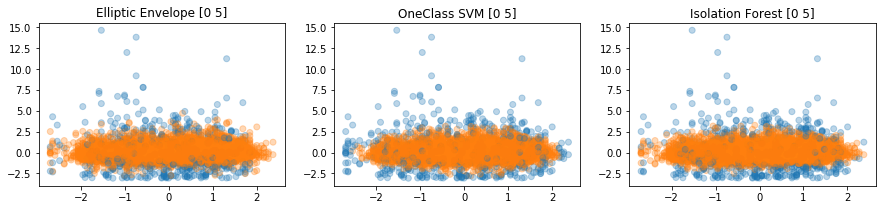

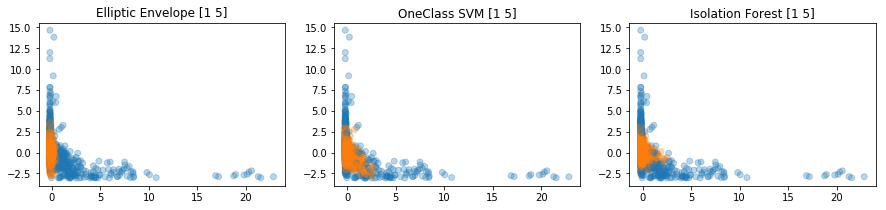

In [24]:
for ax2 in axes_choice[np.random.choice(len(axes_choice),10, False)]:
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    predictions = [ee_pred, svm_pred, isof_pred]
    models = ["Elliptic Envelope", "OneClass SVM", "Isolation Forest"]
    for i in range(3):
        axes[i].scatter(X_scaled[:,ax2[0]],X_scaled[:,ax2[1]], c=plt.cm.tab10(predictions[i]), alpha=.3)
        axes[i].set_title(models[i] + " " + str(ax2))

It is difficult to make any statement on the 3 models from this visualization, because depending on which axis are picked, the models are not performing equally. It would be better to look at a metric like the silhouette score.

In [25]:
ee_sil = silhouette_samples(X_scaled, ee_pred)
np.mean(ee_sil[np.where(ee_pred == 1)[0]])

0.5293415624961451

In [26]:
svm_sil = silhouette_samples(X_scaled, svm_pred)
np.mean(svm_sil[np.where(svm_pred == 1)[0]])

0.5673557985825326

In [27]:
isof_sil = silhouette_samples(X_scaled, isof_pred)
np.mean(isof_sil[np.where(isof_pred == 1)[0]])

0.5867367140419714

According to the Silhouette score of the positive cluster, the Isolation Forest produces the best outlier detection since the inliers form a more compact cluster.

# 3.2

In [28]:
roc_auc_score(X.label,ee.decision_function(X_scaled)), average_precision_score(X.label, ee.decision_function(X_scaled))

(0.08105670117573555, 0.03967570711206184)

In [29]:
roc_auc_score(X.label,oneclass.decision_function(X_scaled)), average_precision_score(X.label, oneclass.decision_function(X_scaled))

(0.42602574864228, 0.11561739974530505)

In [30]:
roc_auc_score(X.label,isof.decision_function(X_scaled)), average_precision_score(X.label, isof.decision_function(X_scaled))

(0.21203524846866711, 0.04350352029790914)

Computing the AUC and average precision scores indicates that the OneClass SVM performs better than the two other models

In [31]:
def convert10(origin):
    copy = np.array([i for i in origin])
    copy[copy==1]=2
    copy[copy==0]=1
    copy[copy==2]=0
    return copy

In [32]:
groundtruth = convert10(X.label)
km_pred = convert10(km.labels_)
ward_pred = convert10(agg.labels_)

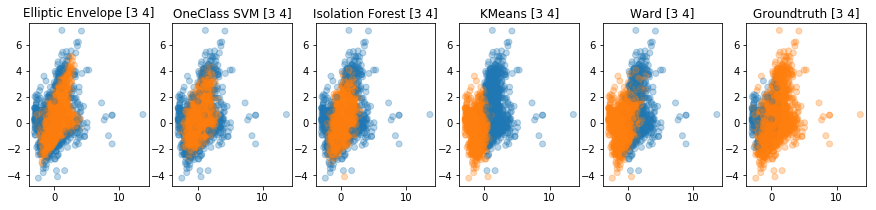

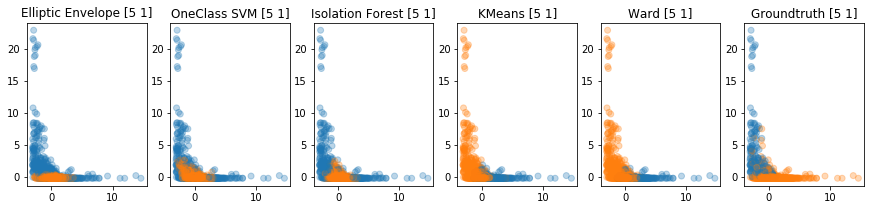

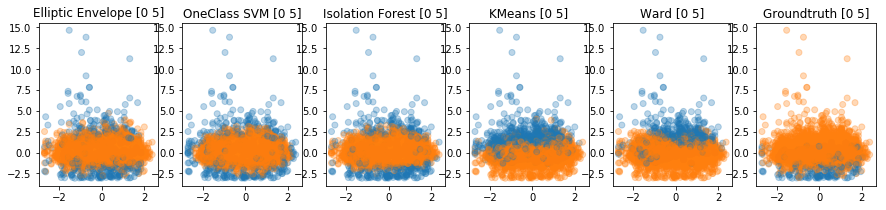

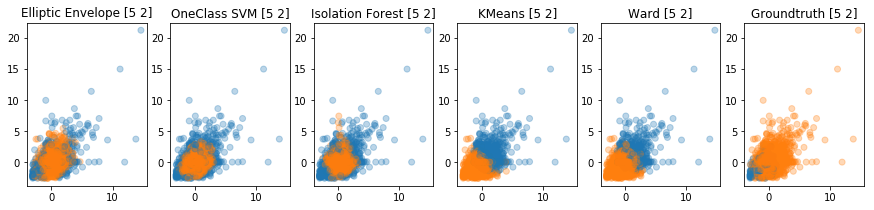

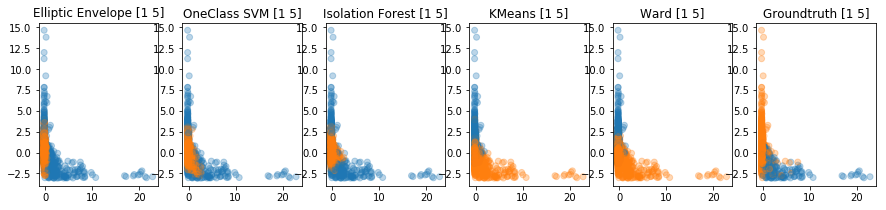

In [33]:
for ax2 in axes_choice[np.random.choice(len(axes_choice),5, False)]:
    fig, axes = plt.subplots(1, 6, figsize=(15, 3))
    predictions = [ee_pred, svm_pred, isof_pred, km_pred, ward_pred, groundtruth]
    models = ["Elliptic Envelope", "OneClass SVM", "Isolation Forest", "KMeans", "Ward", "Groundtruth"]
    for i in range(6):
        axes[i].scatter(X_scaled[:,ax2[0]],X_scaled[:,ax2[1]], c=plt.cm.tab10(predictions[i]), alpha=.3)
        axes[i].set_title(models[i] + " " + str(ax2))

Overall, we can see fromn these plots that the Outlier detection algorithms are much closer to the groundtruth than the clustering algorithms.

In [34]:
predictions = [ee_pred, svm_pred, isof_pred, km_pred, ward_pred]
models = ["Elliptic Envelope", "OneClass SVM", "Isolation Forest", "KMeans", "Ward"]

In [35]:
for i in range(len(predictions)):
    print("{} : {:.2f}".format(models[i], np.sum(groundtruth==predictions[i])/len(X.label)))

Elliptic Envelope : 0.88
OneClass SVM : 0.86
Isolation Forest : 0.87
KMeans : 0.68
Ward : 0.81


When comparing the clustering methods to the outlier detection methods, it appears that the latter recover a larger percentage of the actual classes.

# Imbalanced Classification

In this last part, we come back to a supervised classification algorithm to showcase how much better a supervised approach works over unsupervised methods.

One thing we need to be careful about here is that this classification problem is highly imbalanced.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X.drop('label',axis=1),X.label)

## For the Logistic Regression

In [37]:
oversample_pipe_LR = make_imb_pipeline(RandomOverSampler(), LogisticRegression())
scores = cross_validate(oversample_pipe_LR, X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.8494791455550438, 0.5213711135132186)

In [38]:
oversample_pipe_LR.fit(X_train,y_train)
y_pred = oversample_pipe_LR.predict_proba(X_test)[:, 1]
roc_auc_score(y_test,y_pred), average_precision_score(y_test, y_pred)

(0.8572362839366516, 0.5205988245602692)

Using random oversampling, we get AUC = 0.83 and average precision = 0.46 on the test set

In [39]:
param_grid = {"C": np.logspace(-5, 5, 30)}
grid = GridSearchCV(LogisticRegression(), param_grid, scoring = 'roc_auc', cv = 10)
grid.fit(X_train, y_train)
grid.best_estimator_, grid.best_score_

(LogisticRegression(C=45203.53656360241, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 0.9714378694747258)

In [40]:
y_pred = grid.predict_proba(X_test)[:, 1]
roc_auc_score(y_test,y_pred), average_precision_score(y_test, y_pred)

(0.9730495263009049, 0.7527879891671571)

After tuning a Logistic Regression, we get AUC = 0.97 and average precision = 0.74 on the test set

In [41]:
param_grid = {"C": np.logspace(-5, 5, 30)}
grid = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, scoring = 'roc_auc', cv = 10)
grid.fit(X_train, y_train)
grid.best_estimator_, grid.best_score_

(LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 0.988749600400339)

In [42]:
y_pred = grid.predict_proba(X_test)[:, 1]
roc_auc_score(y_test,y_pred), average_precision_score(y_test, y_pred)

(0.9889838447398192, 0.8317626763901771)

After tuning a Logistic Regression and using balanced class weights, we get AUC = 0.99 and average precision = 0.80 on the test set. Using this has improved the model according to both metrics.

## For the Random Forest Classifier

In [43]:
oversample_pipe_RF = make_imb_pipeline(RandomOverSampler(), RandomForestClassifier(100))
scores = cross_validate(oversample_pipe_RF, X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9960040000767696, 0.9268104860980373)

In [44]:
oversample_pipe_RF.fit(X_train,y_train)
y_pred = oversample_pipe_RF.predict_proba(X_test)[:, 1]
roc_auc_score(y_test,y_pred), average_precision_score(y_test, y_pred)

(0.9953580139988688, 0.9310519068681608)

Using random oversampling, we get AUC = 1.00 and average precision = 0.92 on the test set

In [45]:
param_grid = {"max_depth": np.arange(2, 20)}
grid = GridSearchCV(RandomForestClassifier(100), param_grid, scoring = 'roc_auc', cv = 10)
grid.fit(X_train, y_train)
grid.best_estimator_, grid.best_score_

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=19, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False), 0.9961691737038743)

In [46]:
y_pred = grid.predict_proba(X_test)[:, 1]
roc_auc_score(y_test,y_pred), average_precision_score(y_test, y_pred)

(0.9949912507070136, 0.9212582516721927)

After tuning the Random Forest Classifier, we get AUC = 1.00 and average precision = 0.95 on the test set

In [47]:
param_grid = {"max_depth": np.arange(2, 20)}
grid = GridSearchCV(RandomForestClassifier(100,class_weight='balanced'), param_grid, scoring = 'roc_auc', cv = 10)
grid.fit(X_train, y_train)
grid.best_estimator_, grid.best_score_

(RandomForestClassifier(bootstrap=True, class_weight='balanced',
             criterion='gini', max_depth=17, max_features='auto',
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
             verbose=0, warm_start=False), 0.9960876721059306)

In [48]:
y_pred = grid.predict_proba(X_test)[:, 1]
roc_auc_score(y_test,y_pred), average_precision_score(y_test, y_pred)

(0.9949050834276018, 0.9183437899148397)

After tuning the Random Forest Classifier and using balanced class weights, we get AUC = 1.00 and average precision = 0.92 on the test set. Unlike for the Logistic Regression, using the balanced weights has decreased the model according to both metrics.

The AUC and average precision values found here are much larger than for the clustering models. This is a result we expected.